# Time Series Analysis With Increasingly Complex Methods
In this post I will walk through time series data and how we can attempt to use it to predict future trends.

## What is Time series data?

Time series data is a collection of observations recorded over time.
Time series data can be quite useful to track changes over time.
Additionally, if we are able to accurately model our time series data, we will be able to use historical data to forecast future date.
This capability of data forecasting is a useful tool for any business.

Time series data is typically constituted by the following parts:
- Trend: Long term, persistent changes
- Seasonality: Periodic changes that are typically related to the calendar and repeat yearly
- Noise: variation in the data not explained by trend or seasonality

Let's generate some time series data in Python

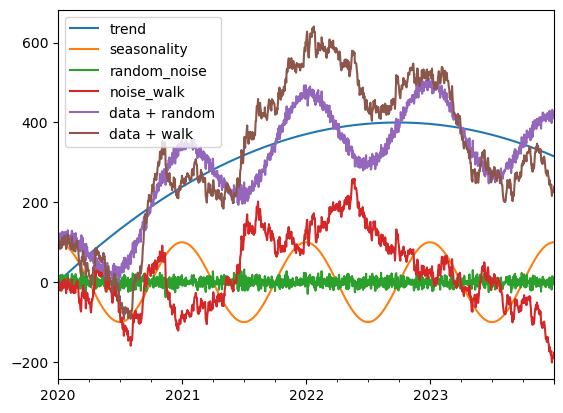

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# make dates
dates = pd.date_range(start='2020-01-01', end='2023-12-31', freq='D')
# get integers for each day generated
x = np.arange(len(dates))

# random number seed for repeatability
rng = np.random.default_rng(seed=51)

# Long term trend is proportional to x^2
trend = -0.0004 * (x - 1000) ** 2 + 400
# Seasonality is sinusoidal with a period of one year
seasonality = 100 * np.cos(x * 2 * np.pi / 365)
# Noise can be random
random = rng.normal(0,10,len(dates))
# Or noise can be dependent on prior values
walk = np.cumsum(random)

df = pd.DataFrame({'trend': trend, 'seasonality': seasonality, 'random_noise': random, 'noise_walk': walk}, index=dates)
df['data + random'] = trend + seasonality + random
df['data + walk'] = trend + seasonality + walk
df.plot()
plt.savefig('data_source.png')
plt.show()

The figure above shows the different components that go into the generated data.
We will use the `data + walk` values to evaluate the models below

## Linear regression
First, we can attempt a linear regression on this data.
The data + walk curve looks decidedly non-linear but we will give it our best shot.

The model can be thought of like this:

$$y_t = x_{1t}\beta_1 + x_{2t}\beta_2 + \epsilon$$

In our case, $y_t$ would be the vaues of `data + walk` at time $t$, $x_{1t}$ is 1 (a constant), $x_{2t}$ is the day number at time $t$, $\beta_1$ is the intercept, $\beta_2$ is the slope, and $\epsilon$ is the error.
The model will adjust the slope and intercept to minimize the difference between the observed and predicted values.

In [2]:
import statsmodels.api as sm

X = sm.add_constant(x)
model = sm.OLS(df['data + walk'], X)
res = model.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:            data + walk   R-squared:                       0.296
Model:                            OLS   Adj. R-squared:                  0.295
Method:                 Least Squares   F-statistic:                     612.0
Date:                Mon, 18 Dec 2023   Prob (F-statistic):          4.03e-113
Time:                        23:47:09   Log-Likelihood:                -9406.2
No. Observations:                1461   AIC:                         1.882e+04
Df Residuals:                    1459   BIC:                         1.883e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        155.7899      7.918     19.676      0.0

So the model decided that a slope of about `0.23` and an intercept of `156` was the best fit for our data, but just about every other metric in the table is telling us that this is not a good fit.
To see why, it might be useful to look at the residuals, or what is present in the data but not explained by the model.
Given the model used, the residual should be explained by the error term, $\epsilon$.
This error term should be independently and identically distributed values, which is deliberately not the case here.
In an ideal case, the residual values would be small and completely random, equally likely to be above or below 0.
Does the residual plot below match this expectation?

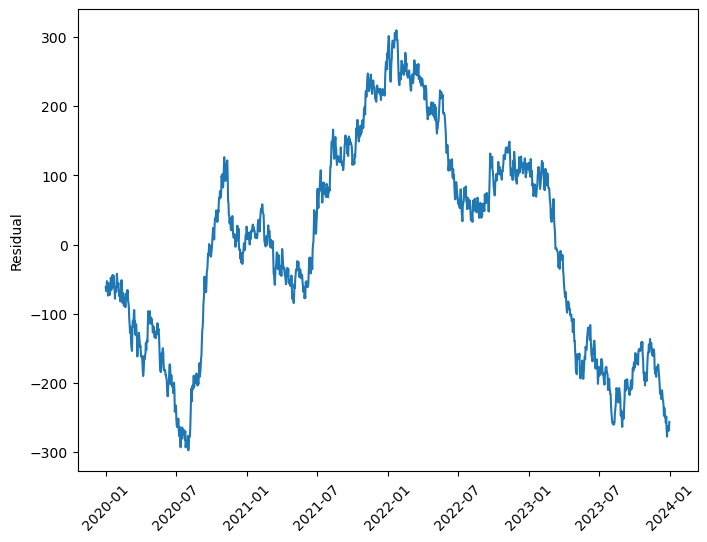

In [3]:
fig, ax = plt.subplots(figsize=(8, 6))

ax.plot(dates, res.resid, label="data")
plt.ylabel('Residual')
plt.xticks(rotation=45)
plt.savefig('OLS.png')
plt.show()

Finally, we plot the model, along with the confidence interval.

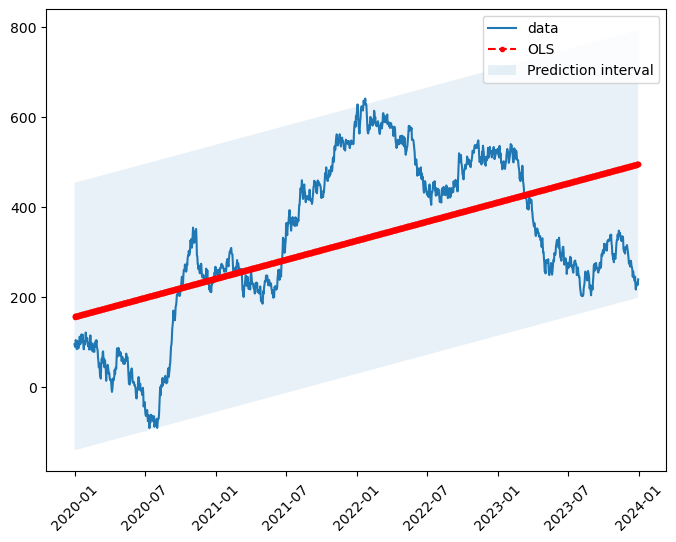

In [4]:
pred_ols = res.get_prediction()
iv_l = pred_ols.summary_frame()["obs_ci_lower"]
iv_u = pred_ols.summary_frame()["obs_ci_upper"]

fig, ax = plt.subplots(figsize=(8, 6))

ax.plot(dates, df['data + walk'], label="data")
ax.plot(dates, res.fittedvalues, "r--.", label="OLS")
ax.fill_between(dates, iv_u, iv_l, alpha=0.1, label='Prediction interval')
ax.legend(loc="best")
plt.xticks(rotation=45)
plt.savefig('OLS.png')
plt.show()

We can do a bit better than that, especially since we know the underlying data.
Least squares regression can be done on non-linear curves, as long as it's still linear in parameters.
So we can create a new model where $\beta_1$ is a constant, but $\beta_2$ is related to the trend and $\beta_3$ is related to the seasonality.

In [5]:
X = np.column_stack((np.ones(len(x)), (x-1000)**2, np.cos(x * 2 * np.pi / 365)))
res = sm.OLS(df['data + walk'], X).fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:            data + walk   R-squared:                       0.800
Model:                            OLS   Adj. R-squared:                  0.800
Method:                 Least Squares   F-statistic:                     2914.
Date:                Mon, 18 Dec 2023   Prob (F-statistic):               0.00
Time:                        23:47:10   Log-Likelihood:                -8486.7
No. Observations:                1461   AIC:                         1.698e+04
Df Residuals:                    1458   BIC:                         1.700e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        462.9543      2.846    162.696      0.0

This fit is better!
It guessed the coefficient for the trend to be `-0.0005` and the coefficient for the seasonality to be `82` which isn't too far off from truth.
There are still obvious trends in the residual so our model is missing something.
The confidence intervals below are tighter than they were on the linear regression as well.

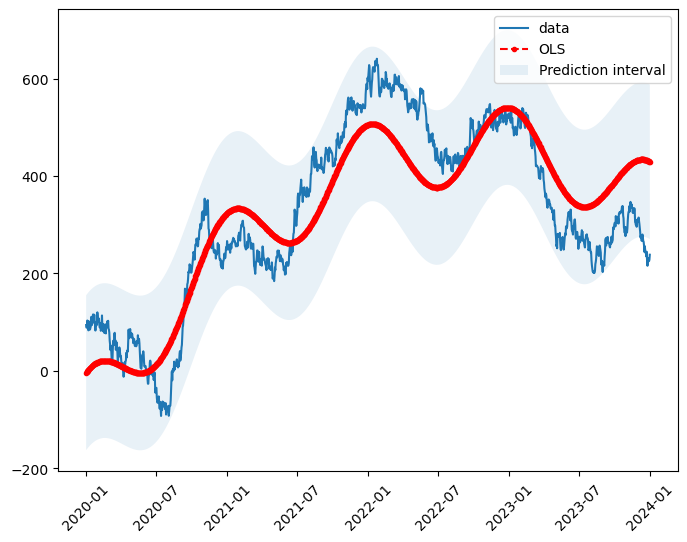

In [6]:
pred_ols = res.get_prediction()
iv_l = pred_ols.summary_frame()["obs_ci_lower"]
iv_u = pred_ols.summary_frame()["obs_ci_upper"]

fig, ax = plt.subplots(figsize=(8, 6))

ax.plot(dates, df['data + walk'], label="data")
ax.plot(dates, res.fittedvalues, "r--.", label="OLS")
ax.fill_between(dates, iv_u, iv_l, alpha=0.1, label='Prediction interval')
ax.legend(loc="best")
plt.xticks(rotation=45)
plt.savefig('OLS.png')
plt.show()

## Auto-Regressive model
In an auotregression, the value at time $t$ is determined by the values at previous times.

$$y_t = \delta + \phi_1y_{t-1} + \ldots + \phi_py_{t-p} + \epsilon_t$$

Here we use an autoregressor that looks at the previous term in order to predict the next value.
The autoregressor in `statsmodels` also allows for seasonality and time trends

In [7]:
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
res = AutoReg(df['data + walk'][:-100], 1, 'ct', seasonal=True).fit()
print(res.summary())

                            AutoReg Model Results                             
Dep. Variable:            data + walk   No. Observations:                 1361
Model:               Seas. AutoReg(1)   Log Likelihood               -5086.142
Method:               Conditional MLE   S.D. of innovations             10.185
Date:                Mon, 18 Dec 2023   AIC                          10192.285
Time:                        23:47:10   BIC                          10244.437
Sample:                    01-02-2020   HQIC                         10211.809
                         - 09-22-2023                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.5188      0.906      0.572      0.567      -1.258       2.295
trend             -0.0005      0.001     -0.604      0.546      -0.002       0.001
s(2,7)             1.3679      1.033

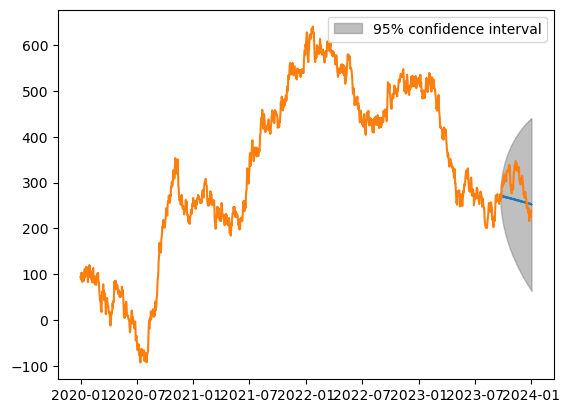

In [8]:
fig = plt.figure()
res.plot_predict(len(df)-100, len(df), fig=fig,)
plt.plot(df['data + walk'])
plt.show()

## Simple Exponential Smoothing
Autoregression can tend to zig-zag and respond late to changes in data.
Another approach is to take a moving average, which will make our model less sensitive to shocks.
It's possible to define a window and just evenly weight each value for y in the window to predict the next value, but here we will weigh each value exponentially, so the terms farther in the past are not weighted as heavily.
The formula is

$$Y_{t+1} = \alpha\left[Y_t + (1-\alpha)Y_{t-1} + (1-\alpha)^2Y_{t-2} + ...\right]$$


In [9]:
from statsmodels.tsa.api import ExponentialSmoothing
res = ExponentialSmoothing(df['data + walk'][:-100], initialization_method='estimated', trend='add', seasonal='add').fit()
print(res.summary())

                       ExponentialSmoothing Model Results                       
Dep. Variable:              data + walk   No. Observations:                 1361
Model:             ExponentialSmoothing   SSE                         141314.579
Optimized:                         True   AIC                           6340.808
Trend:                         Additive   BIC                           6398.184
Seasonal:                      Additive   AICC                          6341.078
Seasonal Periods:                     7   Date:                 Mon, 18 Dec 2023
Box-Cox:                          False   Time:                         23:47:11
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.9999996                alpha                 True
smoothing_trend          

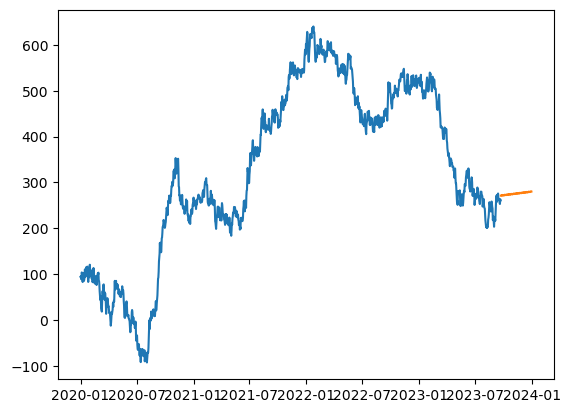

In [10]:
plt.figure()
plt.plot(res.fittedvalues)
plt.plot(res.forecast(100))

## ARIMA
Finally, we get to the ARIMA model, which is just a convenient combination of elements we have already discussed.
AR is for autoregressive, and MA is moving average.
The I is for integration and that comes from differencing the data.
We use the parameters $p$, $d$, and $q$ to indicate the number of autoregressive, difference, and moving average terms, respectively.

Since some of these values can be set to zero, we've already seen some of them in action!

- ARIMA($p$,$d$,$q$)
- ARIMA(1,0,0) + c = autoregression on $y_{t-1}$
- ARIMA(0,1,1) = simple exponential smoothing

In [11]:
from statsmodels.tsa.arima.model import ARIMA
res = ARIMA(df['data + walk'], order=(1,1,1)).fit()
print(res.summary())

                               SARIMAX Results                                
Dep. Variable:            data + walk   No. Observations:                 1461
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -5456.052
Date:                Mon, 18 Dec 2023   AIC                          10918.104
Time:                        23:47:11   BIC                          10933.962
Sample:                    01-01-2020   HQIC                         10924.020
                         - 12-31-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6097      0.781     -0.781      0.435      -2.140       0.920
ma.L1          0.6253      0.770      0.813      0.416      -0.883       2.134
sigma2       103.1496      3.859     26.730      0.0

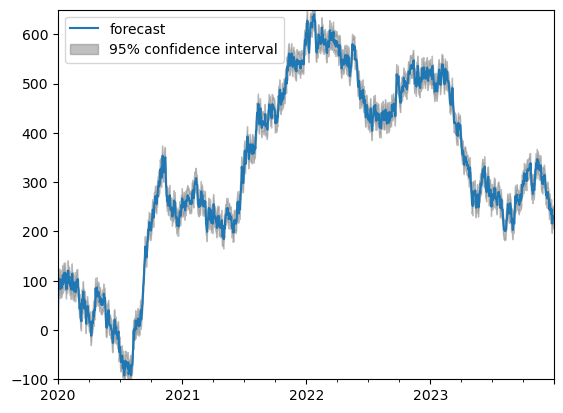

In [12]:
from statsmodels.graphics.tsaplots import plot_predict
plot_predict(res)
plt.ylim([-100,650])
plt.show()